In [ ]:

import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
import sys
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
from scipy.io import wavfile
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from scipy import signal


In [ ]:
GOODSOUNDS_FILE = os.path.join('GS', 'GS1.wav')
BADSOUNDS_FILE = os.path.join('BS', 'BS2.wav')

def load_wav(filename, up=0, down=1, single=0):
    samplerate, data = wavfile.read(filename=filename)
    if single:
        data = np.mean(data, axis=1)
    if up != 0 and down != 0:
        data = signal.resample_poly(data, up=up, down=up)
        samplerate = samplerate * up / down
    return samplerate, data

samplerate, data = load_wav(GOODSOUNDS_FILE, up=3, down=8, single=1)


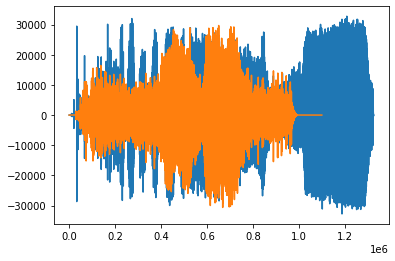

[]
<class 'list'>
float64


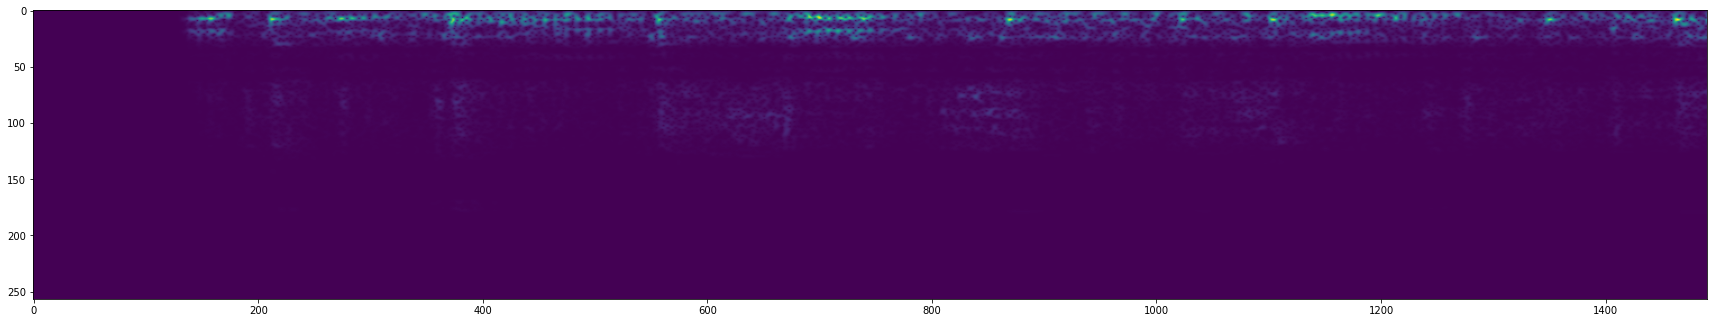

<dtype: 'float64'>
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 flatten (Flatten)           (None, 6019376)           0         
                                                                 
 dense (Dense)               (None, 128)               770480256 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 770,482,865
Trainable params: 770,482,865
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
1/1 [========

In [ ]:

GOODSOUNDS_FILE = os.path.join('GS', 'GS1.wav')
BADSOUNDS_FILE = os.path.join('BS', 'BS2.wav')

_, wave = load_wav(GOODSOUNDS_FILE, up=3, down=8, single=1)
_, nwave = load_wav(BADSOUNDS_FILE, up=3, down=8, single=1)
plt.plot(wave)
plt.plot(nwave)
plt.show()
POS = 'GS'
NEG =  'BS'
pos = []
neg = []
print(pos)
print(type(pos))
for file in os.listdir('GS'):
    _, tensor_wave = load_wav(os.path.join( 'GS', file), up=3, down=8, single=1)
    tensor_wave = tensor_wave[:48000]
    pos.append(tensor_wave)
pos = tf.data.Dataset.from_tensor_slices(pos)
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
for file in os.listdir('BS'):
    _, tensor_wave = load_wav(os.path.join( 'BS', file), up=3, down=8, single=1)
    tensor_wave = tensor_wave[:48000]
    neg.append(tensor_wave)
neg = tf.data.Dataset.from_tensor_slices(neg)
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)
lengths = []
for file in os.listdir('GS'):
    _, tensor_wave = load_wav(os.path.join( 'GS', file), up=3, down=8, single=1)
    lengths.append(len(tensor_wave))
tf.math.reduce_mean(lengths)
tf.math.reduce_min(lengths)
tf.math.reduce_max(lengths)
def preprocess(wav, label): 
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float64)
    print(wav.dtype)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)
train = data.take(36)
test = data.skip(36).take(15)
samples, labels = train.as_numpy_iterator().next()
samples.shape


model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
model.summary()
hist = model.fit(train, epochs=4, validation_data=test, verbose=True)
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()
X_test, y_test = test.as_numpy_iterator().next()
yhat = model.predict(X_test)


In [ ]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav
mp3 = os.path.join('PYTHON', 'tests', 'T1.mp3')
wav = load_mp3_16k_mono(mp3)
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
samples, index = audio_slices.as_numpy_iterator().next()
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]
from itertools import groupby
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()
calls
results = {}
for file in os.listdir(os.path.join('PYTHON', 'tests')):
    FILEPATH = os.path.join('PYTHON','tests', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat
results
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed
import csv
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'chainsaw_returns'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])


In [1]:
conda search _tflow_select --info

Loading channels: ...working... done
_tflow_select 2.1.0 gpu
-----------------------
file name   : _tflow_select-2.1.0-gpu.conda
name        : _tflow_select
version     : 2.1.0
build       : gpu
build number: 0
size        : 3 KB
subdir      : win-64
url         : https://repo.anaconda.com/pkgs/main/win-64/_tflow_select-2.1.0-gpu.conda
md5         : d8310d81844c4bc2dd8aa8e1eb4ec396
timestamp   : 2018-10-05 03:23:33 UTC
dependencies: []


_tflow_select 2.2.0 eigen
-------------------------
file name   : _tflow_select-2.2.0-eigen.conda
name        : _tflow_select
version     : 2.2.0
build       : eigen
build number: 0
size        : 3 KB
subdir      : win-64
url         : https://repo.anaconda.com/pkgs/main/win-64/_tflow_select-2.2.0-eigen.conda
md5         : 386e3bf3d93648532de4d58219c5d59e
timestamp   : 2018-10-05 03:23:35 UTC
dependencies: []


_tflow_select 2.3.0 eigen
-------------------------
file name   : _tflow_select-2.3.0-eigen.conda
name        : _tflow_select
version     : 2.3

In [ ]:
conda info